In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as K

In [2]:
# COMP3710 Project
# Question 4: Segment the ISICs data set with the Improved UNet [1] with all labels having a minimum Dice similarity
# coefficient of 0.8 on the test set. [Normal Difficulty]

# Student Name: Xiao Sun
# Studeng Number: 45642586


In [3]:


img_GroundTruth = os.listdir(r'C:\Users\s4564258\Downloads\ISIC2018_Task1_Training_GroundTruth_x2')
img_input = os.listdir(r'C:\Users\s4564258\Downloads\ISIC2018_Task1-2_Training_Input_x2')

len(img_GroundTruth), len(img_input)


(2596, 2596)

In [4]:
img_GroundTruth[0], img_GroundTruth[-1]

('ATTRIBUTION.txt', 'LICENSE.txt')

In [5]:


def load_data():
    
    
    # we use img_input[1:-1] because the first and last file is not image document.
    #load input images and process into tf dataset.
    img_input = os.listdir(r'C:\Users\s4564258\Downloads\ISIC2018_Task1-2_Training_Input_x2')
    img_input = [os.path.join(r'C:\Users\s4564258\Downloads\ISIC2018_Task1-2_Training_Input_x2', path) for path in img_input[1:-1]]
    path_img_input = tf.data.Dataset.from_tensor_slices(img_input)
    image_input_ds = path_img_input.map(data_processing_norm_input, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    
    #load mask images and process into tf dataset.
    img_GroundTruth = os.listdir(r'C:\Users\s4564258\Downloads\ISIC2018_Task1_Training_GroundTruth_x2')
    img_GroundTruth = [os.path.join(r'C:\Users\s4564258\Downloads\ISIC2018_Task1_Training_GroundTruth_x2', path) for path in img_GroundTruth[1:-1]]
    path_img_GroundTruth = tf.data.Dataset.from_tensor_slices(img_GroundTruth)
    image_mask_ds = path_img_GroundTruth.map(data_processing_norm_GT, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    
    image_ds = tf.data.Dataset.zip((image_input_ds, image_mask_ds))
    
    # implot_show(image_input_ds.take(4))
    implot_show(image_ds.take(4))
    
    return image_ds
    
def data_processing_norm_input(image):
    # process input img data into tf tensor, and normalization.
    
    img_raw = tf.io.read_file(image)
    image = tf.image.decode_jpeg(img_raw, channels=3)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range
    
    return image
    
    
def data_processing_norm_GT(image):
    # process mask (GroundTruth) img data into tf tensor, and normalization.
    
    img_raw = tf.io.read_file(image)
    image = tf.image.decode_jpeg(img_raw, channels=1)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range
    
    return image
    
def implot_show(ds):
    # using imshow to vertify correctly load and process data
    
    for input_img, mask_img in ds:
        
        print(input_img.shape)
        display_list = [input_img, mask_img]
        plt.figure(figsize=(18, 18))
        for i in range(2):
            print(display_list[i].shape)
            plt.subplot(1, 2, i+1)
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')
        plt.show()
        

In [6]:
def split_train_test_val(image_ds):
    # split the whole tf data set into train, validation and test.
    
    # this step will slow down the process.
    # size = len(list(image_ds))
    size = 2594
    
    train_size = int(0.7 * size)
    val_size = int(0.15 * size)
    test_size = int(0.15 * size)
    
    train_image = image_ds.take(train_size)
    val_image = image_ds.skip(train_size)
    test_image = val_image.take(test_size)
    val_image = val_image.skip(test_size)
    
    return train_image, val_image, test_image

(256, 256, 3)
(256, 256, 3)
(256, 256, 1)


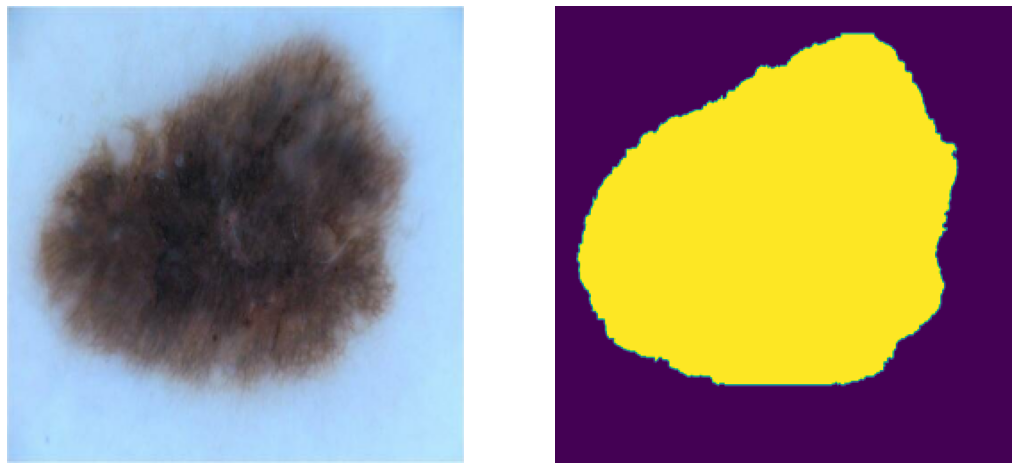

(256, 256, 3)
(256, 256, 3)
(256, 256, 1)


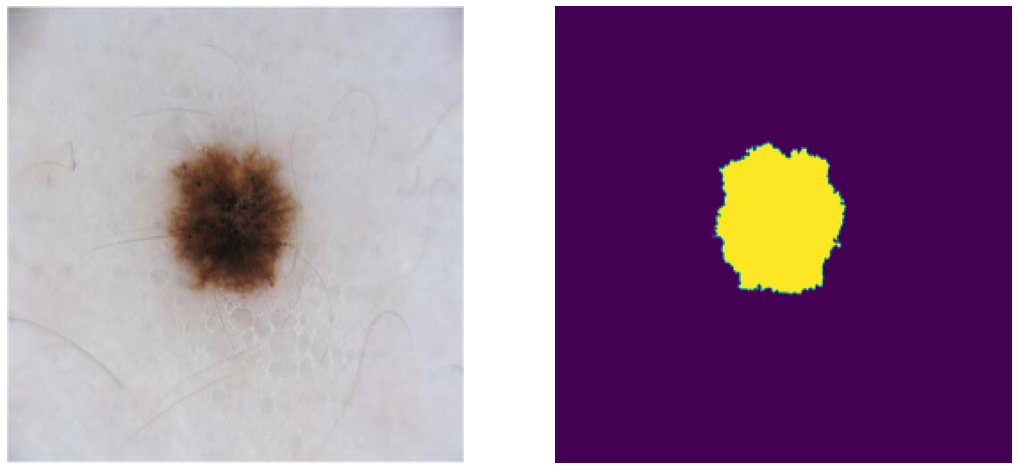

(256, 256, 3)
(256, 256, 3)
(256, 256, 1)


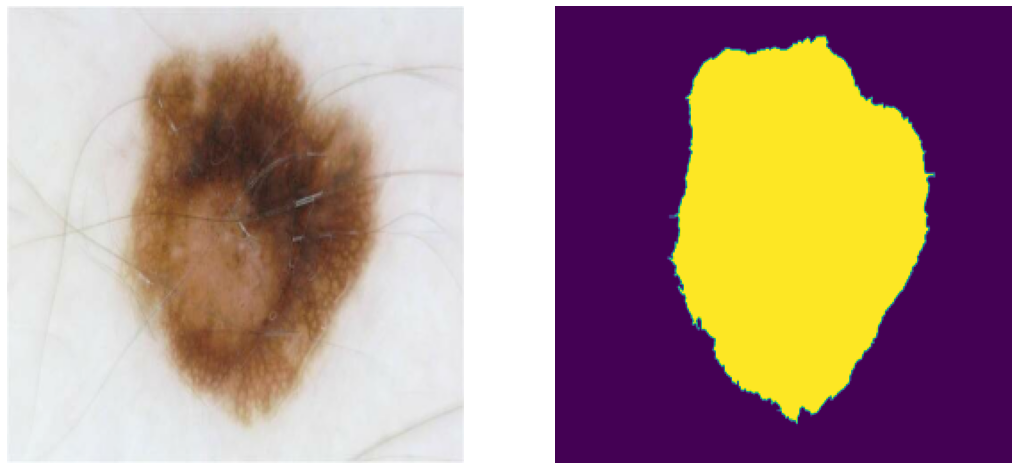

(256, 256, 3)
(256, 256, 3)
(256, 256, 1)


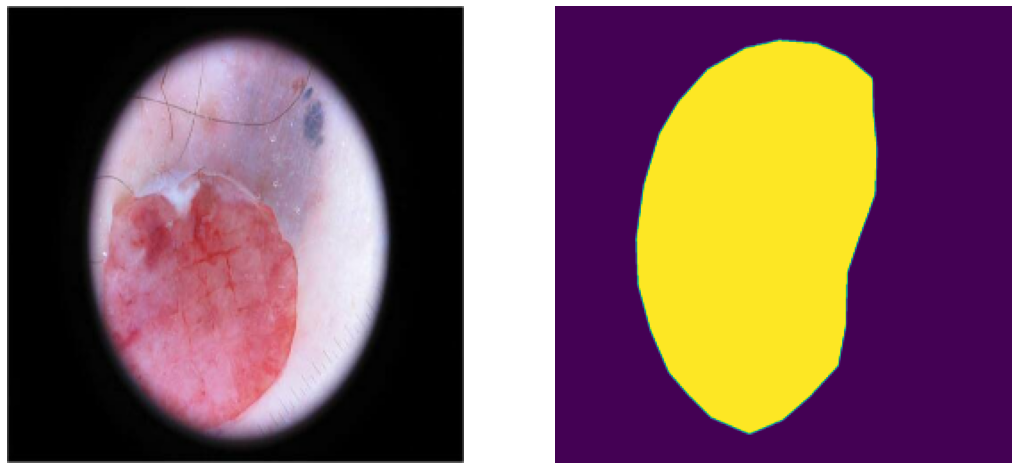

In [18]:
image_ds = load_data()

image_train, image_val, image_test = split_train_test_val(image_ds)
#mask_train, mask_val, mask_test = split_train_test_val(image_mask_ds)


BATCH_SIZE=32
STEPS_PER_EPOCH =1815//BATCH_SIZE
image_train = image_train.batch(BATCH_SIZE).repeat()
image_val = image_val.batch(BATCH_SIZE)
image_test = image_test.batch(1)


In [123]:
len(list(image_val))

7

In [8]:
# leaky ReLU, no batchnormalization


def UNet_context_module(filters, inp, layer_name):
    # Each context_module consists of two 3x3 conv layers and a dropout(0.3) in between.
    
    x1 = layers.Conv2D(filters, kernel_size =3, padding = 'same')(inp)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.LeakyReLU(alpha=0.01)(x1)
    x1 = layers.Dropout(.3)(x1)
    x2 = layers.Conv2D(filters, kernel_size =3, padding = 'same')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.LeakyReLU(alpha=0.01)(x2)

    return x2
    
def UNet_upsampling_module(filters, inp):
    # ...It is like a layer that combines the UpSampling2D and Conv2D layers into one layer. 
    
    # what twice means in paper (Answer from Piazza: kernel size 2 by 2)?
    x1 = layers.UpSampling2D(size=(2,2))(inp)
    x2 = layers.Conv2D(filters, kernel_size =3, padding = 'same')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.LeakyReLU(alpha=0.01)(x2)
    
    return x2
    
    
def UNet_localization_module(filters, inp):
    # A localization module consists of a 3x3x3 convolution followed by a 1x1x1 convolution that halves the
    # number of feature maps.
    
    x1 = layers.Conv2D(filters, kernel_size =3, padding = 'same')(inp)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.LeakyReLU(alpha=0.01)(x1)
    
    x1 = layers.Dropout(.3)(x1)
    x2 = layers.Conv2D(filters, kernel_size =1, padding = 'same')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.LeakyReLU(alpha=0.01)(x2)
    
    return x2
    
    

In [9]:
def Improved_UNet_model():
    
    filters = 16
    input_layer = Input((256,256,3))
    
    # block 1:
    block1_x1 = layers.Conv2D(filters, kernel_size =3, padding = 'same')(input_layer)
    #block1_x1 = layers.BatchNormalization()(block1_x1)
    block1_x1 = layers.LeakyReLU(alpha=0.01)(block1_x1)
    #block1_x1 = layers.Dropout(0.3)(block1_x1)
    
    block1_x2 = UNet_context_module(filters, block1_x1, "context_module1")
    
    output_b1 = layers.Add()([block1_x1, block1_x2])
    
    
    # block 2:
    block2_x1 = layers.Conv2D(filters*2, kernel_size =3, strides = 2, padding = 'same')(output_b1)
    #block2_x1 = layers.BatchNormalization()(block2_x1)
    block2_x1 = layers.LeakyReLU(alpha=0.01)(block2_x1)
    #block2_x1 = layers.Dropout(0.3)(block2_x1)
    
    block2_x2 = UNet_context_module(filters*2, block2_x1, "context_module2")
    
    output_b2 = layers.Add()([block2_x1, block2_x2])
    
    
    # block 3:
    block3_x1 = layers.Conv2D(filters*4, kernel_size =3, strides = 2, padding = 'same')(output_b2)
    #block3_x1 = layers.BatchNormalization()(block3_x1)
    block3_x1 = layers.LeakyReLU(alpha=0.01)(block3_x1)
    #block3_x1 = layers.Dropout(0.3)(block3_x1)
    
    block3_x2 = UNet_context_module(filters*4, block3_x1, "context_module3")
    
    output_b3 = layers.Add()([block3_x1, block3_x2])
    
    
    # block 4:
    block4_x1 = layers.Conv2D(filters*8, kernel_size =3, strides = 2, padding = 'same')(output_b3)
    #block4_x1 = layers.BatchNormalization()(block4_x1)
    block4_x1 = layers.LeakyReLU(alpha=0.01)(block4_x1)
    #block4_x1 = layers.Dropout(0.3)(block4_x1)
    
    block4_x2 = UNet_context_module(filters*8, block4_x1, "context_module4")
    
    output_b4 = layers.Add()([block4_x1, block4_x2])
    
    
    # block 5:
    block5_x1 = layers.Conv2D(filters*16, kernel_size =3, strides = 2, padding = 'same')(output_b4)
    #block5_x1 = layers.BatchNormalization()(block5_x1)
    block5_x1 = layers.LeakyReLU(alpha=0.01)(block5_x1)
    #block5_x1 = layers.Dropout(0.3)(block5_x1)
    
    block5_x2 = UNet_context_module(filters*16, block5_x1, "context_module5")
    
    output_b5 = layers.Add()([block5_x1, block5_x2])
    
    
    # up_block 6:
    block6_x1 = UNet_upsampling_module(filters*8, output_b5)
    # connection
    output_b6 = layers.concatenate([output_b4, block6_x1])
    
    
    # up_block 7:
    block7_x1 = UNet_localization_module(filters*8, output_b6)
    block7_x2 = UNet_upsampling_module(filters*4, block7_x1)
    # connection
    output_b7 = layers.concatenate([output_b3, block7_x2])
    
    
    # up_block 8:
    block8_x1 = UNet_localization_module(filters*4, output_b7)
    block8_x2 = UNet_upsampling_module(filters*2, block8_x1)
    # connection
    output_b8 = layers.concatenate([output_b2, block8_x2])
    
    
    # up_block 9:
    block9_x1 = UNet_localization_module(filters*2, output_b8)
    block9_x2 = UNet_upsampling_module(filters, block9_x1)
    # connection
    output_b9 = layers.concatenate([output_b1, block9_x2])
    
    # upscale
    segmentation_1 = layers.Conv2D(1, kernel_size =3, padding = 'same')(block7_x1)
    segmentation_1 = layers.UpSampling2D(size=(8,8))(segmentation_1)
    segmentation_2 = layers.Conv2D(1, kernel_size =3, padding = 'same')(block8_x1)
    segmentation_2 = layers.UpSampling2D(size=(4,4))(segmentation_2)
    final_block_output = layers.Conv2D(1, kernel_size =3, padding = 'same')(output_b9)
    
    output = layers.Add()([segmentation_1, segmentation_2, final_block_output])
    #output = layers.BatchNormalization()(output)
    output = layers.Activation('sigmoid')(output)
    
    improved_unet_model = Model(input_layer, output, name="improved_unet_model")
    improved_unet_model.summary()
    
    return improved_unet_model
    

In [59]:
improved_unet_model = Improved_UNet_model()

Model: "improved_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 256, 256, 16) 448         input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_150 (LeakyReLU)     (None, 256, 256, 16) 0           conv2d_168[0][0]                 
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 256, 256, 16) 2320        leaky_re_lu_150[0][0]            
________________________________________________________________________________

In [11]:
# Dice coef

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [60]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.2)

# learning rate decay
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.985,
    staircase=True)
# opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
opt = SGD(learning_rate=lr_schedule)


improved_unet_model.compile(optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef])

VALIDATION_STEPS = 390//BATCH_SIZE

model_history = improved_unet_model.fit(image_train,steps_per_epoch=STEPS_PER_EPOCH ,epochs=200, validation_data=image_val)

Train for 56 steps, validate for 13 steps
Epoch 1/200
56/56 [==============================] - 32s 576ms/step - loss: 0.7060 - dice_coef: 0.2940 - val_loss: 0.7278 - val_dice_coef: 0.2722
Epoch 2/200
56/56 [==============================] - 32s 568ms/step - loss: 0.6232 - dice_coef: 0.3768 - val_loss: 0.7747 - val_dice_coef: 0.2253
Epoch 3/200
56/56 [==============================] - 32s 572ms/step - loss: 0.4935 - dice_coef: 0.5065 - val_loss: 0.8662 - val_dice_coef: 0.1338
Epoch 4/200
56/56 [==============================] - 32s 571ms/step - loss: 0.4163 - dice_coef: 0.5837 - val_loss: 0.9347 - val_dice_coef: 0.0653
Epoch 5/200
56/56 [==============================] - 31s 556ms/step - loss: 0.3892 - dice_coef: 0.6108 - val_loss: 0.9587 - val_dice_coef: 0.0413
Epoch 6/200
56/56 [==============================] - 32s 571ms/step - loss: 0.3734 - dice_coef: 0.6266 - val_loss: 0.9209 - val_dice_coef: 0.0791
Epoch 7/200
56/56 [==============================] - 32s 571ms/step - loss: 0.3622

Epoch 112/200
56/56 [==============================] - 32s 577ms/step - loss: 0.1969 - dice_coef: 0.8031 - val_loss: 0.2083 - val_dice_coef: 0.7917
Epoch 113/200
56/56 [==============================] - 33s 592ms/step - loss: 0.1955 - dice_coef: 0.8045 - val_loss: 0.2106 - val_dice_coef: 0.7894
Epoch 114/200
56/56 [==============================] - 33s 582ms/step - loss: 0.1952 - dice_coef: 0.8048 - val_loss: 0.2269 - val_dice_coef: 0.7731
Epoch 115/200
56/56 [==============================] - 32s 566ms/step - loss: 0.1919 - dice_coef: 0.8081 - val_loss: 0.2268 - val_dice_coef: 0.7732
Epoch 116/200
56/56 [==============================] - 32s 576ms/step - loss: 0.1915 - dice_coef: 0.8085 - val_loss: 0.2558 - val_dice_coef: 0.7442
Epoch 117/200
56/56 [==============================] - 32s 575ms/step - loss: 0.1918 - dice_coef: 0.8082 - val_loss: 0.2414 - val_dice_coef: 0.7586
Epoch 118/200
56/56 [==============================] - 32s 571ms/step - loss: 0.1894 - dice_coef: 0.8106 - val_l

In [12]:
# not run
# learning rate decay for adam
improved_unet_model_2 = Improved_UNet_model()

initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.985,
    staircase=True)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


improved_unet_model_2.compile(optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef])


model_history = improved_unet_model_2.fit(image_train,steps_per_epoch=STEPS_PER_EPOCH ,epochs=200, validation_data=image_val)

Model: "improved_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_25 (LeakyReLU)      (None, 256, 256, 16) 0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 16) 2320        leaky_re_lu_25[0][0]             
________________________________________________________________________________

56/56 [==============================] - 41s 737ms/step - loss: 0.3488 - dice_coef: 0.6512 - val_loss: 0.8147 - val_dice_coef: 0.1853
Epoch 2/200
56/56 [==============================] - 35s 619ms/step - loss: 0.3171 - dice_coef: 0.6829 - val_loss: 0.7081 - val_dice_coef: 0.2919
Epoch 3/200
56/56 [==============================] - 33s 583ms/step - loss: 0.3046 - dice_coef: 0.6953 - val_loss: 0.9713 - val_dice_coef: 0.0287
Epoch 4/200
56/56 [==============================] - 32s 572ms/step - loss: 0.2943 - dice_coef: 0.7057 - val_loss: 0.5440 - val_dice_coef: 0.4560
Epoch 5/200
56/56 [==============================] - 35s 623ms/step - loss: 0.2749 - dice_coef: 0.7251 - val_loss: 0.9033 - val_dice_coef: 0.0967
Epoch 6/200
56/56 [==============================] - 32s 569ms/step - loss: 0.2778 - dice_coef: 0.7222 - val_loss: 0.9479 - val_dice_coef: 0.0521
Epoch 7/200
56/56 [==============================] - 33s 595ms/step - loss: 0.2801 - dice_coef: 0.7199 - val_loss: 0.6006 - val_dice_coe

Epoch 57/200
56/56 [==============================] - 32s 568ms/step - loss: 0.1226 - dice_coef: 0.8774 - val_loss: 0.2046 - val_dice_coef: 0.7954
Epoch 58/200
56/56 [==============================] - 32s 567ms/step - loss: 0.1185 - dice_coef: 0.8815 - val_loss: 0.2400 - val_dice_coef: 0.7600
Epoch 59/200
56/56 [==============================] - 32s 571ms/step - loss: 0.1171 - dice_coef: 0.8829 - val_loss: 0.3148 - val_dice_coef: 0.6852
Epoch 60/200
56/56 [==============================] - 32s 575ms/step - loss: 0.1147 - dice_coef: 0.8853 - val_loss: 0.2695 - val_dice_coef: 0.7305
Epoch 61/200
56/56 [==============================] - 32s 565ms/step - loss: 0.1164 - dice_coef: 0.8836 - val_loss: 0.2972 - val_dice_coef: 0.7028
Epoch 62/200
56/56 [==============================] - 32s 573ms/step - loss: 0.1167 - dice_coef: 0.8833 - val_loss: 0.1949 - val_dice_coef: 0.8051
Epoch 63/200
56/56 [==============================] - 38s 671ms/step - loss: 0.1166 - dice_coef: 0.8834 - val_loss: 0.

56/56 [==============================] - 31s 552ms/step - loss: 0.0834 - dice_coef: 0.9165 - val_loss: 0.1605 - val_dice_coef: 0.8395
Epoch 113/200
56/56 [==============================] - 32s 566ms/step - loss: 0.0832 - dice_coef: 0.9168 - val_loss: 0.2269 - val_dice_coef: 0.7731
Epoch 114/200
56/56 [==============================] - 31s 558ms/step - loss: 0.0827 - dice_coef: 0.9173 - val_loss: 0.1654 - val_dice_coef: 0.8346
Epoch 115/200
56/56 [==============================] - 32s 580ms/step - loss: 0.0783 - dice_coef: 0.9217 - val_loss: 0.1721 - val_dice_coef: 0.8279
Epoch 116/200
56/56 [==============================] - 31s 555ms/step - loss: 0.0768 - dice_coef: 0.9232 - val_loss: 0.1628 - val_dice_coef: 0.8372
Epoch 117/200
56/56 [==============================] - 32s 572ms/step - loss: 0.0749 - dice_coef: 0.9251 - val_loss: 0.1728 - val_dice_coef: 0.8272
Epoch 118/200
56/56 [==============================] - 32s 574ms/step - loss: 0.0750 - dice_coef: 0.9250 - val_loss: 0.1743 - 

56/56 [==============================] - 32s 572ms/step - loss: 0.0535 - dice_coef: 0.9465 - val_loss: 0.1563 - val_dice_coef: 0.8437
Epoch 168/200
56/56 [==============================] - 33s 582ms/step - loss: 0.0529 - dice_coef: 0.9471 - val_loss: 0.1767 - val_dice_coef: 0.8233
Epoch 169/200
56/56 [==============================] - 33s 584ms/step - loss: 0.0550 - dice_coef: 0.9450 - val_loss: 0.1842 - val_dice_coef: 0.8158
Epoch 170/200
56/56 [==============================] - 31s 558ms/step - loss: 0.0554 - dice_coef: 0.9446 - val_loss: 0.1965 - val_dice_coef: 0.8035
Epoch 171/200
56/56 [==============================] - 32s 565ms/step - loss: 0.0517 - dice_coef: 0.9483 - val_loss: 0.1871 - val_dice_coef: 0.8129
Epoch 172/200
56/56 [==============================] - 32s 580ms/step - loss: 0.0516 - dice_coef: 0.9484 - val_loss: 0.1796 - val_dice_coef: 0.8204
Epoch 173/200
56/56 [==============================] - 32s 571ms/step - loss: 0.0502 - dice_coef: 0.9498 - val_loss: 0.1984 - 

In [19]:
improved_unet_model_2.evaluate(image_test)

13/13 [==============================] - 10s 736ms/step - loss: 0.1946 - dice_coef: 0.8054


[0.19455271500807542, 0.8054473]

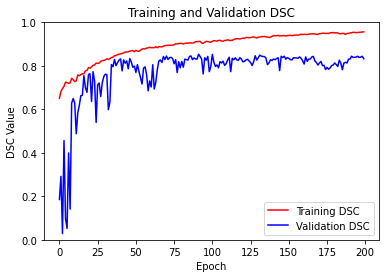

In [14]:
def plot_DSC():
    dsc = model_history.history['dice_coef']
    val_dsc = model_history.history['val_dice_coef']

    epochs = range(200)

    plt.figure()
    plt.plot(epochs, dsc, 'r', label='Training DSC')
    plt.plot(epochs, val_dsc, 'b', label='Validation DSC')
    plt.title('Training and Validation DSC')
    plt.xlabel('Epoch')
    plt.ylabel('DSC Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()
plot_DSC()

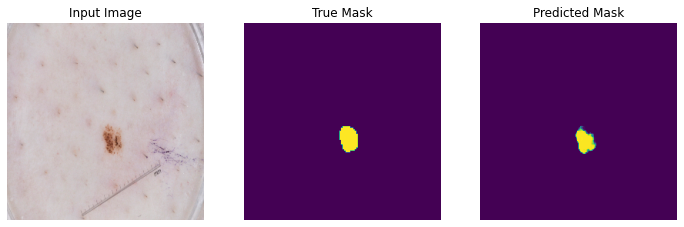

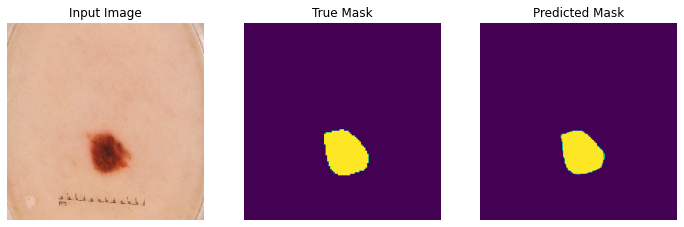

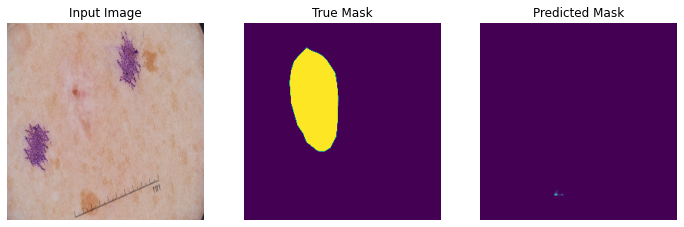

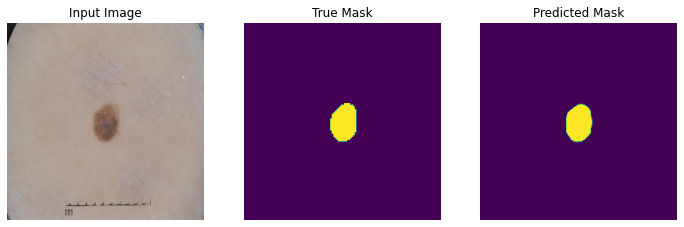

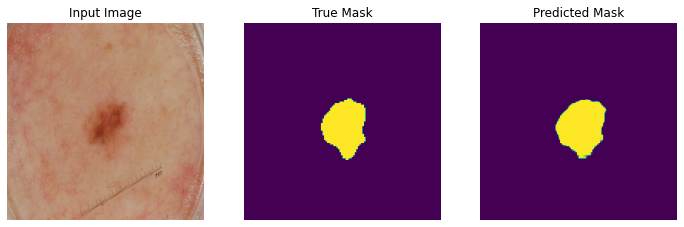

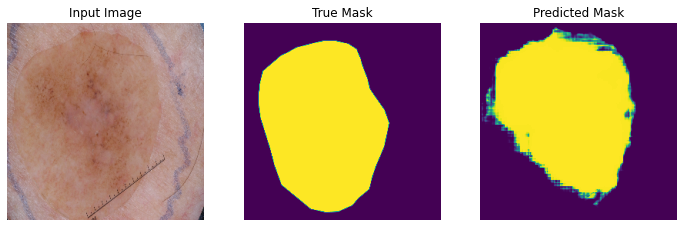

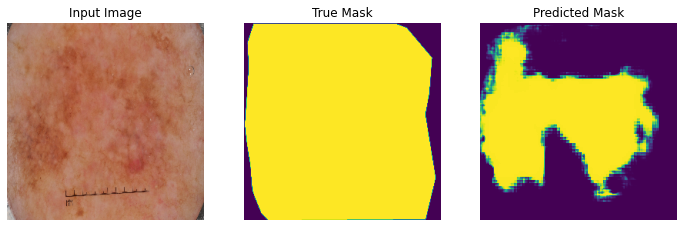

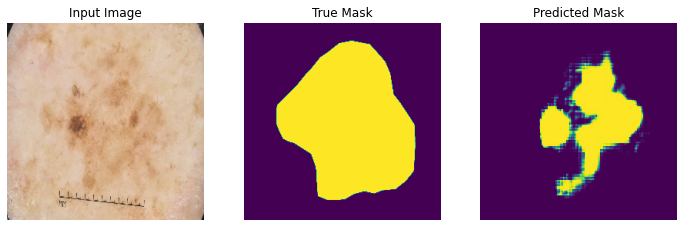

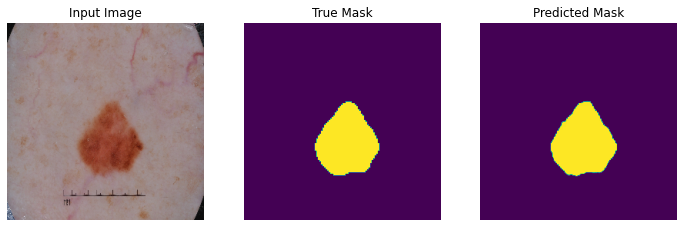

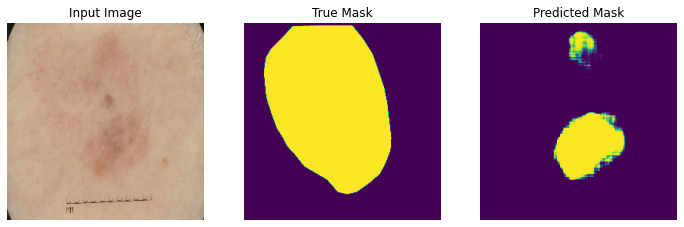

In [17]:

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def implot_show_predict(ds):
    # using imshow to vertify correctly load and process data
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for input_img, mask_img in ds:
        
        input_img_pred = tf.expand_dims(input_img, axis=0)
        pred_mask = improved_unet_model_2.predict(input_img_pred)
        display_list = [input_img, mask_img, pred_mask[0]]
        
        plt.figure(figsize=(12, 12))
        for i in range(len(display_list)):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')
        plt.show()

image_train, image_val, image_test = split_train_test_val(image_ds)
image_test_random = image_test.shuffle(10)
implot_show_predict(image_test_random.take(10))

In [74]:

improved_unet_model_3 = Improved_UNet_model()

# learning rate decay
initial_learning_rate = 0.08
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.985,
    staircase=True)
# opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
opt = SGD(learning_rate=lr_schedule)


improved_unet_model_3.compile(optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef])


model_history = improved_unet_model_3.fit(image_train,steps_per_epoch=STEPS_PER_EPOCH ,epochs=30, validation_data=image_val)

Model: "improved_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_224 (Conv2D)             (None, 256, 256, 16) 448         input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_200 (LeakyReLU)     (None, 256, 256, 16) 0           conv2d_224[0][0]                 
__________________________________________________________________________________________________
conv2d_225 (Conv2D)             (None, 256, 256, 16) 2320        leaky_re_lu_200[0][0]            
________________________________________________________________________________

56/56 [==============================] - 35s 623ms/step - loss: 0.4012 - dice_coef: 0.5988 - val_loss: 0.9389 - val_dice_coef: 0.0611
Epoch 2/30
56/56 [==============================] - 32s 565ms/step - loss: 0.3382 - dice_coef: 0.6618 - val_loss: 0.9935 - val_dice_coef: 0.0065
Epoch 3/30
56/56 [==============================] - 32s 578ms/step - loss: 0.3116 - dice_coef: 0.6884 - val_loss: 0.9960 - val_dice_coef: 0.0040
Epoch 4/30
56/56 [==============================] - 33s 585ms/step - loss: 0.2823 - dice_coef: 0.7176 - val_loss: 0.6454 - val_dice_coef: 0.3546
Epoch 5/30
56/56 [==============================] - 33s 582ms/step - loss: 0.2654 - dice_coef: 0.7346 - val_loss: 0.6909 - val_dice_coef: 0.3091
Epoch 6/30
56/56 [==============================] - 32s 575ms/step - loss: 0.2518 - dice_coef: 0.7481 - val_loss: 0.4384 - val_dice_coef: 0.5616
Epoch 7/30
56/56 [==============================] - 31s 553ms/step - loss: 0.2408 - dice_coef: 0.7592 - val_loss: 0.3533 - val_dice_coef: 0.6

KeyboardInterrupt: 

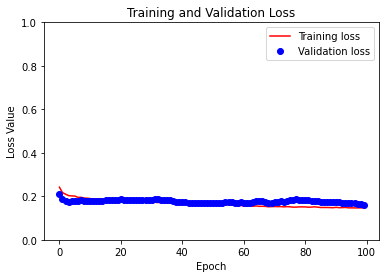

In [113]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(100)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

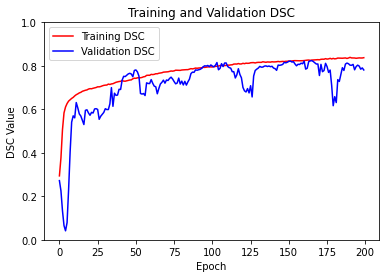

In [62]:
def plot_DSC():
    dsc = model_history.history['dice_coef']
    val_dsc = model_history.history['val_dice_coef']

    epochs = range(200)

    plt.figure()
    plt.plot(epochs, dsc, 'r', label='Training DSC')
    plt.plot(epochs, val_dsc, 'b', label='Validation DSC')
    plt.title('Training and Validation DSC')
    plt.xlabel('Epoch')
    plt.ylabel('DSC Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()
plot_DSC()

In [67]:
improved_unet_model.evaluate(image_test)

389/389 [==============================] - 9s 24ms/step - loss: 0.2620 - dice_coef: 0.7380


[0.26198254376266794, 0.7380177]

In [44]:
image_input_ds, image_mask_ds
len(list(image_input_ds))

2594

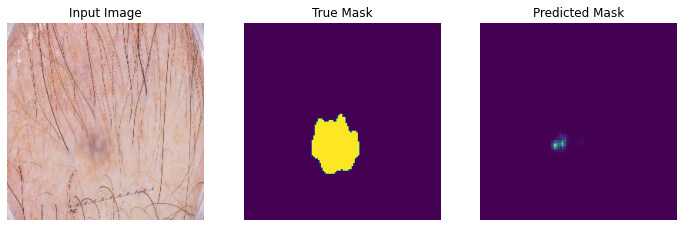

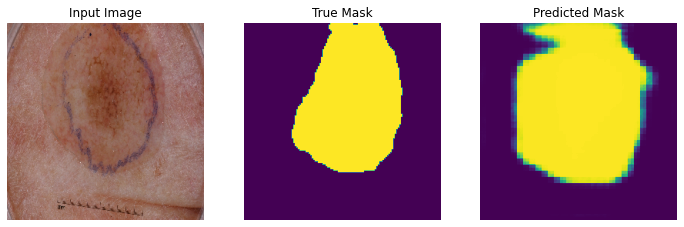

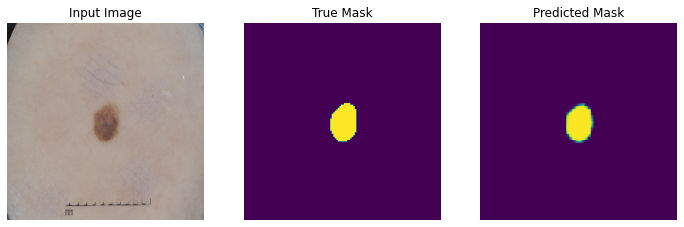

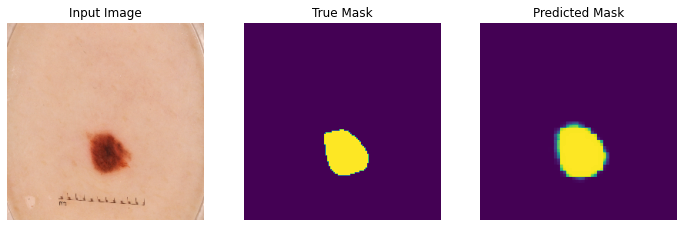

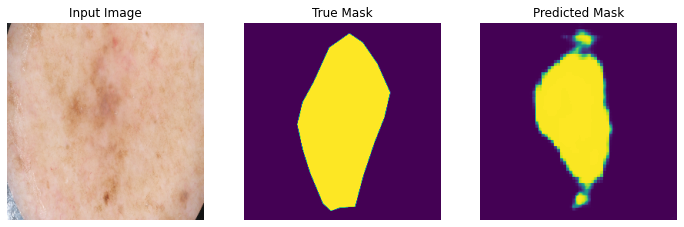

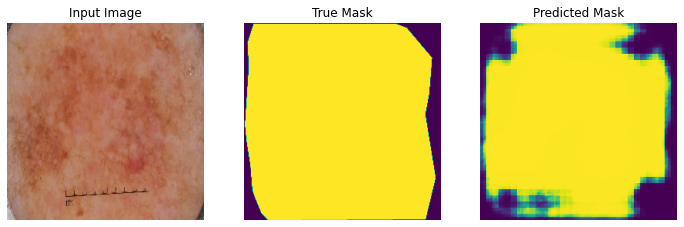

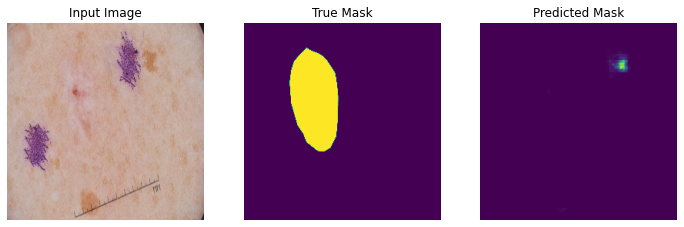

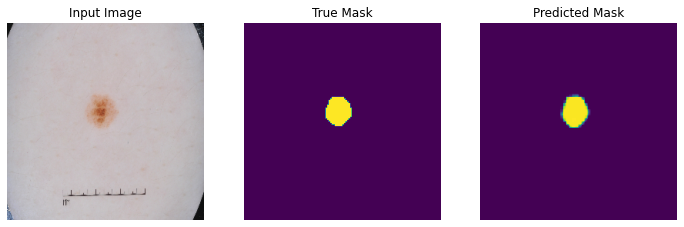

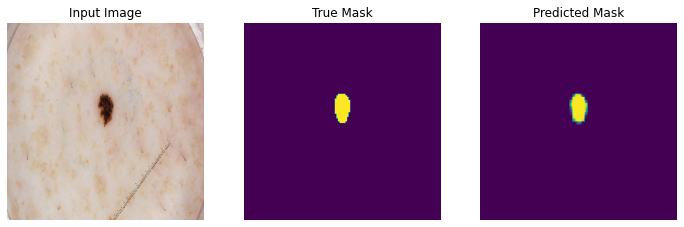

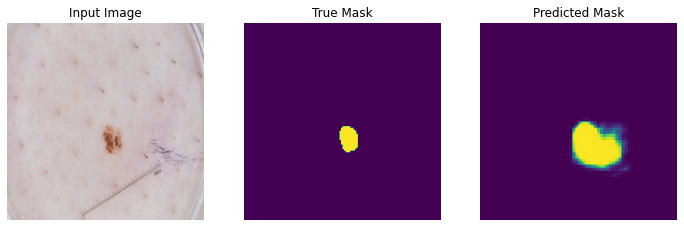

In [69]:

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def implot_show_predict(ds):
    # using imshow to vertify correctly load and process data
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for input_img, mask_img in ds:
        
        input_img_pred = tf.expand_dims(input_img, axis=0)
        pred_mask = improved_unet_model.predict(input_img_pred)
        display_list = [input_img, mask_img, pred_mask[0]]
        
        plt.figure(figsize=(12, 12))
        for i in range(len(display_list)):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')
        plt.show()

image_train, image_val, image_test = split_train_test_val(image_ds)
implot_show_predict(image_test.take(10))

In [ ]:
first i used relu, however the result is noot very good.
Then i follow the instruction in paper, using leaky relu. 

sigmoid and softmax

Then try using optimizer = 'adam', sgd with different learning rate
sgd: training--0.81; val--0.7; test--0.69;
    
then add batch normalization
after 50 epoch
training--0.85; val--0.79; test--0.75;

In last element wise add, use average to instead (not used)

# why use sgd instead of adam, try adam and know difference

because overfitting, i add dropout layer